In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

import sys

sys.path.append("../")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from kernels import GaussianKernel
from data import get_synthetic_dataset, get_synthetic_X, get_matrix_hermites, get_new_data
from feature_decomp import Monomial
from utils import ensure_torch
from mlps import MLP
from tools import get_log_log_linear_fit

from mupify import mupify, rescale

plt.rc("figure", dpi=100, facecolor=(1, 1, 1))
plt.rc("font", family='stixgeneral', size=14)
plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
plt.rc("mathtext", fontset='cm')

In [ ]:
X, data_eigvals = get_synthetic_X(d=dim, N=N, offset=offset, alpha=alpha)

X, _, H, monomials, fra_eigvals, _, _ = get_synthetic_dataset(X, data_eigvals, noise_size=noise_size, yoffset=yoffset, beta=beta, normalized=True, kerneltype=kerneltype, **kwargs)

In [ ]:
def plot_time_to_learn_eigenvalue(eigvals, timekeys, target_monomials, scale='log', **kwargs):
    degrees = np.array([target_monomial.degree() for target_monomial in target_monomials])
    colors = kwargs.get("colors", ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"])
    markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']
    max_degrees  = np.array([target_monomial.max_degree() for target_monomial in target_monomials])
    uniq_md     = np.unique(max_degrees)
    md2marker   = {md: markers[i % len(markers)] for i, md in enumerate(uniq_md)}

    pairs = np.unique(np.stack([degrees, max_degrees], axis=1), axis=0)

    for degree, md in pairs:
        idxs = np.flatnonzero((degrees == degree) & (max_degrees == md))
        if kwargs.get("errorbar", False):
            plt.errorbar((eigvals[idxs])**(-1), timekeys[idxs], yerr=kwargs.get("yerr")[idxs], color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
        else:
            plt.scatter((eigvals[idxs])**(-1), timekeys[idxs], marker=md2marker[md], color=colors[degree%7], alpha=kwargs.get("alpha", 1))
    plt.xscale(scale)
    plt.yscale(scale)
    plt.xlabel(f"FRA Eigval $\\lambda^{{-1}}$")
    plt.ylabel(f"Time to learn "+kwargs.get("breakpoint", ""))
    plt.title(f"Time to learn vs FRA Eigval")


def plot_time_vs_error(all_losses, target_monomials, fra_eigvals, locs, *, colors=None, plotindex = 26):
    colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"] if not colors else colors

    fig, axes = plt.subplots(2, 1, figsize=(7,9), sharex=True)
    ax = axes[0]
    for idx, target_monomial in enumerate(target_monomials):
        if idx > plotindex:
            break
        ax.plot(all_losses[idx].mean(axis=0)/all_losses[idx].mean(axis=0)[0], label=f"Monomial {target_monomial} w/ $\\lambda$ {fra_eigvals[int(locs[idx].cpu().numpy())]:.3e}", color=colors[idx%7], lw=1.8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Relative Train MSE (norm by init val)")
    ax.grid(True, ls='--', alpha=.4)
    ax = axes[1]
    for idx, target_monomial in enumerate(target_monomials):
        if idx > plotindex:
            break
        ax.plot(all_losses[idx].mean(axis=0), label=f"{target_monomial}, $\\lambda_{{FRA}}={fra_eigvals[int(locs[idx].cpu().numpy())]:.2e}$", color=colors[idx%7], lw=1.8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("Absolute Train MSE")
    ax.grid(True, ls='--', alpha=.4)
    fig.supxlabel("Gradient steps")
    return fig, axes


def get_slope_and_intercept(fra_eigvals, locs, pct_breakpoints, breakindex = 1, trainindex = 100):
    xaxis = (fra_eigvals[locs.long()][:trainindex].cpu())**(-1.)
    ys = ensure_torch(pct_breakpoints).mean(axis=-1)[:trainindex, breakindex]
    slope, intercept = get_log_log_linear_fit(xaxis, ys)
    return slope, intercept, xaxis


def plot_eigval_vs_traintime(slope, intercept, xaxis, fra_eigvals, locs, pct_breakpoints, target_monomials,
                             breakindex = 1, trainindex = 100, gamma=1, *, breakpoint=f"(error < 50% starting err)"):
    plot_time_to_learn_eigenvalue(fra_eigvals[locs.long()][:trainindex].cpu(), pct_breakpoints.mean(axis=-1)[:trainindex, breakindex], target_monomials[:trainindex],
                                  scale='log', breakpoint=breakpoint, marker='s', alpha=0.5, errorbar=True, yerr=pct_breakpoints.var(axis=-1)[:trainindex, breakindex]**(0.5))
    plt.plot(xaxis, 10**(intercept)*xaxis**(slope), color='k', label=f"log(y) = {slope:.2f}*log(x)+{intercept:.1f}")
    plt.ylabel("Time to learn (error < 50% starting err)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(f"Time to learn vs FRA eigval, MLP $\\gamma ={gamma}$")


import matplotlib.colors as mcolors
def lighten(color, amount=0.5):
    rgb = mcolors.to_rgb(mcolors.XKCD_COLORS.get(color, color))
    if amount >= 0:
        new_rgb = tuple(c + (1 - c) * amount for c in rgb)
    else:
        new_rgb = tuple(c * (1 + amount) for c in rgb)
    # Clip values to [0, 1]
    new_rgb = tuple(min(max(x, 0), 1) for x in new_rgb)
    return new_rgb

In [ ]:
result = expt_fm.load("result.pickle")
monomials = result["monomials"]
d_eff = result["d_eff"]
print(f"d_eff = {d_eff:.2f}")
ridge = result["ridge"]
et_yhat = ExptTrace.deserialize(result["y_hat"])

emp_eigvals = result["emp_eigvals"]
hehe_eigvals = result["th_eigvals"]
iso_eigvals = result["iso_eigvals"]

targets = expt_fm.load("targets.pickle")
source_exps = np.array(list(targets.keys()))

emp_eigvecs = expt_fm.load("emp_eigvecs.npy")
H = expt_fm.load("H.npy")

ntest = result["n_test"]
ntrains = et_yhat.get_axis("ntrain")
trials = et_yhat.get_axis("trial")

In [ ]:
dim = 3072
ns = np.logspace(0, 3.3, 10, dtype=int)
# N = max(ns)
N = 5_000
offset=3
alpha=1.2
bsz = 512
cutoff_mode = 40_000
kerneltype = GaussianKernel
normalized = True

X, y, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=Monomial({}), dim=dim, N=N, offset=offset,
                                                                      alpha=alpha, cutoff_mode=cutoff_mode, kerneltype=kerneltype,
                                                                      normalized=normalized)
target_monomials = [Monomial({10: 1}), Monomial({190:1}), Monomial({0:2}), Monomial({2:1, 3:1}), Monomial({15:1, 20:1}), Monomial({0:3})]
X_full, y_full, locs, H, monomials, fra_eigvals, data_eigvals = get_all_targets(target_monomials=target_monomials, dim=dim, N=N, offset=offset,
                                                                      alpha=alpha, cutoff_mode=cutoff_mode, kerneltype=kerneltype,
                                                                      normalized=normalized)
lr = 1e-2
width = 8192
gamma = 1

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]
markers = ['x', 's', 'o', '^', 'D', '*', 'v', 'p', 'h']

loss_checkpoints = (5e-1, 2e-2)
percent_thresholds = (0.75, 0.01)
U, lambdas, Vt = torch.linalg.svd(X_full, full_matrices=False)

max_iter = int(1e4)
min_iter = int(1e2)
window = 60
eval_every = 10
patience = 2
slope_eps = 8e-5
rel_improve_eps = 8e-2
ema_smoother = 0.9
use_log_time = True
stopper = PlateauStopper(min_iter=min_iter, window=window, eval_every=eval_every, patience=patience, slope_eps=slope_eps,
                                     rel_improve_eps=rel_improve_eps, ema_smoother=ema_smoother, use_log_time=use_log_time)

Generating monomials: 100%|██████████| 10000/10000 [00:00<00:00, 22564.46step/s]


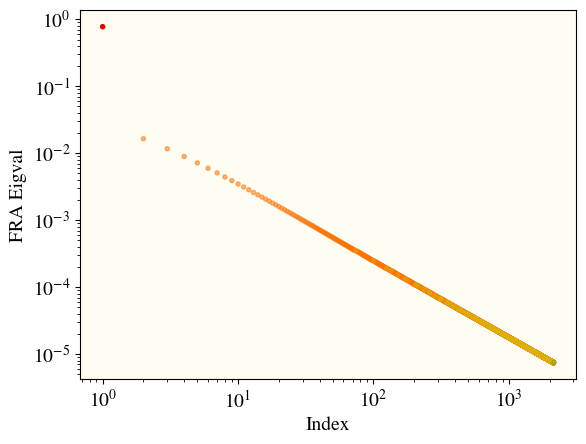

In [ ]:
degrees = np.array([monomial.degree() for monomial in monomials[:1+int(locs[-1])]])
indices = np.linspace(1, int(locs[-1])+1, 1+int(locs[-1]))
for degree in np.unique(degrees):
    idxs = np.where(np.array(degrees) == degree)[0]
    plt.scatter(indices[idxs], fra_eigvals[idxs].cpu(), color=colors[degree%7], linestyle='', marker='.', alpha=1/(degree+1),)
plt.yscale("log")
plt.xscale('log')
plt.xlabel("Index")
plt.ylabel("FRA Eigval")
plt.show()

In [ ]:
def trial_count_fn(n):
    # if n <= 10:
    #     return 30
    if n <= 50:
        return 20
    elif n <= 500:
        return 10
    elif n <= 5000:
        return 3
    else:
        return 1

trial_counts = np.array([trial_count_fn(n) for n in ns], dtype=int)
max_trials   = int(trial_counts.max())

all_losses = np.full((len(ns), len(target_monomials), max_trials, max_iter), np.nan, dtype=float)
# final_losses = np.full((len(ns), len(target_monomials), max_trials), np.nan, dtype=float)
pct_breakpoints = np.full((len(ns), len(target_monomials), len(percent_thresholds), max_trials), np.nan, dtype=float)

total_iters = int(len(target_monomials) * trial_counts.sum())
pbar = tqdm(total=total_iters, desc="Processing items")

Processing items:   0%|          | 0/816 [00:31<?, ?it/s]


In [ ]:
import gc

for idx, target_monomial in enumerate(target_monomials):
    for nidx, n in enumerate(ns):
        num_trials_n = int(trial_counts[nidx])

        for trial in range(num_trials_n):
            pbar.set_postfix(
                current_item=f"Mon:{target_monomial} n:{n} trial:{trial+1}/{num_trials_n}",
                refresh=False
            )
            X, y = get_new_data(lambdas, Vt, target_monomial, dim, n, data_eigvals, N)
            model = MLP(d_in=dim, depth=2, d_out=1, width=width).to(device)

            outdict = train_network(model=model, lambdas=lambdas, Vt=Vt, monomial=target_monomial, dim=dim, bsz=bsz,
                                    data_eigvals=data_eigvals, N=N, lr=lr, max_iter=max_iter, percent_thresholds=percent_thresholds,
                                    gamma=gamma, ema_smoother=ema_smoother, fixed_X=X, fixed_y=y, stopper=stopper)

            # final_losses[nidx, idx, trial] = outdict["test_losses"][-1]
            all_losses[nidx, idx, trial] = outdict["test_losses"]
            pct_breakpoints[nidx, idx, :, trial] = outdict["timekeys"]

            del outdict, model, X, y
            gc.collect()
            stopper.reset()

            pbar.update(1)

        # term_losses = all_losses[nidx, idx]
        # loss_mean = np.nanmean(term_losses, axis=0)
        # loss_std  = np.nanstd(term_losses, axis=0, ddof=1)
        # ec = mcolors.to_rgba(colors[target_monomial.degree()%7], 0.15)


        # plt.errorbar(np.arange(1, max_iter+1, 1), loss_mean, yerr=loss_std, fmt=markers[target_monomial.max_degree()%len(markers)],
        #              color=colors[target_monomial.degree()%7], label=f"n={n}", ecolor=ec)#, color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])

        # plt.title(f"MLP Learning Monomial {target_monomials[idx]} from fixed n")
        # plt.xlabel("Timestep")
        # plt.ylabel(f"Test Error")
        # plt.xscale("log")
        # plt.legend()
        # plt.show()
pbar.close()

Processing items:   4%|▍         | 32/816 [1:19:48<32:44:10, 150.32s/it, current_item=Mon:$x_{10}$ n:2 trial:12/20]

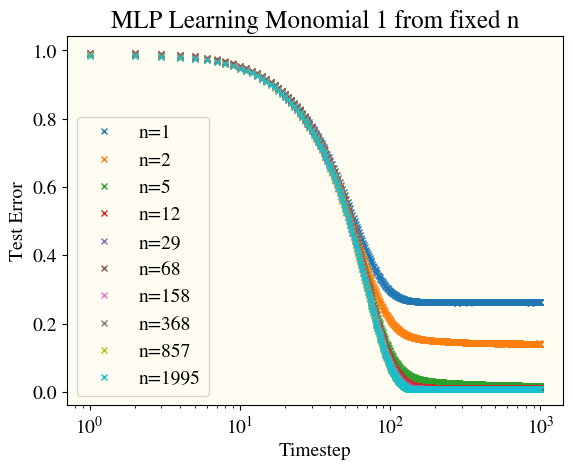

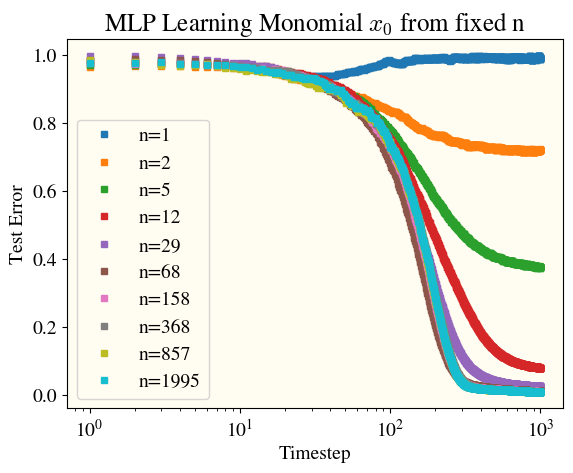

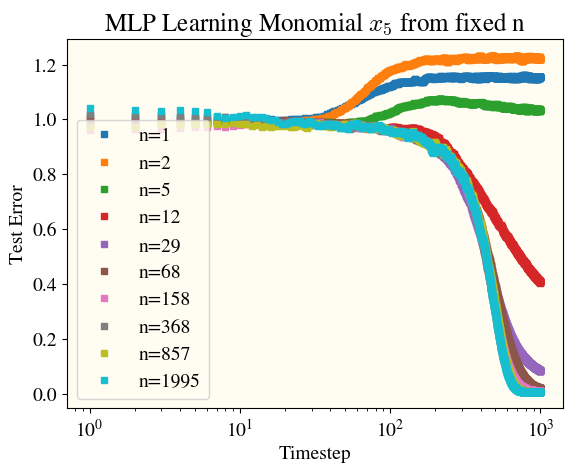

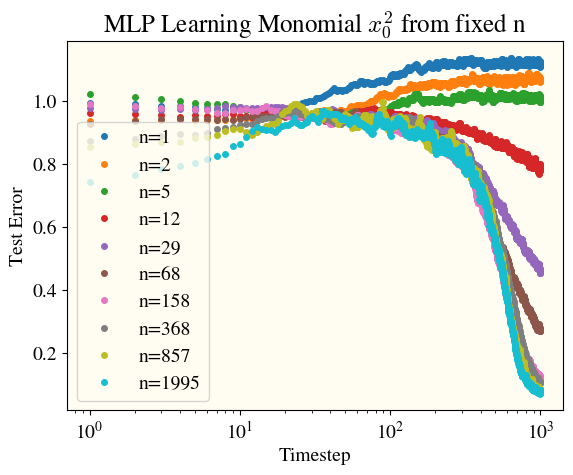

In [ ]:
for term in range(len(target_monomials)):
    target_monomial = target_monomials[term]
    for i in range(len(all_losses)):
        term_losses = all_losses[i, term]
        loss_mean = np.nanmean(term_losses, axis=0)
        loss_std  = np.nanstd(term_losses, axis=0, ddof=1)
        ec = mcolors.to_rgba(colors[target_monomial.degree()%7], 0.15)
        plt.errorbar(np.arange(1, max_iter+1, 1), loss_mean, fmt=markers[target_monomial.max_degree()%len(markers)], label=f"n={ns[i]}", ms=4, yerr=None)#, yerr=loss_std, ecolor=ec)#, color=colors[degree%7], alpha=kwargs.get("alpha", 1), fmt=md2marker[md])
    plt.title(f"MLP Learning Monomial {target_monomials[term]} from fixed n")
    plt.xlabel("Timestep")
    plt.ylabel(f"Test Error")
    plt.xscale("log")
    plt.legend()
    plt.show()

In [ ]:
use_ots_correction = False
from eigenlearning import eigenlearning

ns_dense = np.logspace(0, 4, 100, dtype=int)

for idx, target_monomial in enumerate(target_monomials):
    eigvals = fra_eigvals
    coeffs = np.zeros_like(eigvals.cpu())
    coeffs[int(locs[idx])] = 1.0

    fra_ridge = max(0, 1 - eigvals.sum())
    el_fra = lambda n: eigenlearning(n, eigvals.cpu().numpy(), coeffs, ridge=fra_ridge)
    mse_el_fra = np.array([el_fra(n)["test_mse"] for n in ns_dense])

    if use_ots_correction:
        train_mse = np.array([el_fra(n)["train_mse"] for n in ns_dense])
        mse_el_fra = (N*mse_el_fra - train_mse*ns) / (N - ns_dense)
    
    plt.plot(ns, mse_el_fra,
             color=colors[target_monomial.degree()%7], lw=2)

for term, target_monomial in enumerate(target_monomials):
    term_losses = all_losses[:, term]
    loss_mean = np.nanmean(term_losses, axis=1)
    loss_std  = np.nanstd(term_losses, axis=1, ddof=1)
    plt.errorbar(ns, loss_mean[:, -1], label=target_monomial, fmt=markers[target_monomial.max_degree()%len(markers)],
                color=colors[term%7],
                yerr=loss_std[:, -1], alpha=0.7)
# plt.scatter(ns, all_losses[:, 1, :, -1].mean(axis=-1), label=target_monomials[1])
plt.xscale("log")
plt.xlabel("n")
plt.ylabel(f"(ema .9) Test Loss at {max_iter}")
plt.legend()
plt.title("MLP Num train samples vs final test error")
plt.show()

ModuleNotFoundError: No module named 'eigenlearning'